<a href="https://colab.research.google.com/github/LeticiaVieirg/crack_thermal_detection/blob/main/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importação das bibliotecas

In [1]:
import cv2
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation, Add, Input, AveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

import numpy as np
import os, sys
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt
import itertools
import scipy.stats
import tensorflow as tf
from keras import applications, optimizers, Input
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder='/content/drive/MyDrive/CAI_SWTB/train'

Estruturando o dataset

In [4]:
#image resolution
image_width = 224
image_height = 224
channels = 3 #rgb

train_files = []
i=0
for classes in ['Faulty', 'Healthy']:
    print(os.path.join(folder, classes))
    onlyfiles = [f for f in os.listdir(os.path.join(folder, classes)) if os.path.isfile(os.path.join(folder, classes, f ))]
    for _file in onlyfiles:
        train_files.append(_file)

dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels),
                     dtype=np.float32)
y_dataset = []


/content/drive/MyDrive/CAI_SWTB/train/Faulty
/content/drive/MyDrive/CAI_SWTB/train/Healthy


In [5]:
i = 0

valid_extensions=(".jpg", ".jpeg", ".png", ".bmp")

for classes in ['Faulty', 'Healthy']: #catregorias das imagens
    onlyfiles = [f for f in os.listdir(os.path.join(folder, classes))
     if f.lower().endswith(valid_extensions) and
             os.path.isfile(os.path.join(folder, classes, f))]

    #if os.path.isfile(os.path.join(folder, classes, f))] #seleciona as imagens e ignora pastas
    for _file in onlyfiles: #Percorre os arquivos da pasta
        img_path = os.path.join(folder, classes, _file)
        img = load_img(img_path, target_size=(image_height, image_width)) #redimenciona a iamgem
        x = img_to_array(img)

        dataset[i] = x #armazenando os dados
        mapping = {'Faulty': 0 , 'Healthy': 1} #dicionario
        y_dataset.append(mapping[classes])  #rotulo das imagens

        i += 1
        if i == 30000:
            print("%d images to array" % i)
            break

print("All images to array!")

All images to array!


Normalizando dados

In [6]:
#Normalização
dataset = dataset.astype('float32')
dataset /= 255

In [7]:
classes = ['Faulty', 'Healthy']

# Dicionário para armazenar o índice da primeira imagem de cada classe
first_image_index = {}

# Encontra o índice da primeira imagem de cada classe
for i, label in enumerate(y_dataset):
    if label not in first_image_index:
        first_image_index[label] = i

# Configura a grade para exibir as imagens
num_classes = len(set(y_dataset))
num_images_per_class = 1
num_cols = num_classes
num_rows = num_images_per_class

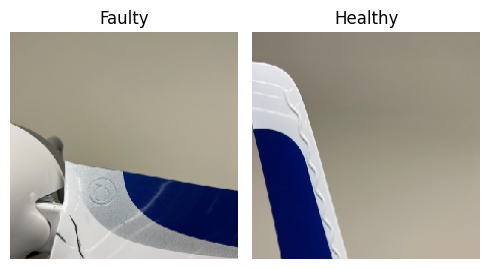

In [8]:
# Cria uma figura com uma grade de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 15))

# Loop através de cada classe
for i in range(num_classes):
    # Obtém o índice da primeira imagem da classe
    idx = first_image_index[i]

    # Obtém a imagem e converte para RGB
    pixels = dataset[idx]

    # Exibe a imagem no subplot correspondente
    axes[i].imshow(pixels, cmap='Spectral')
    axes[i].axis('off')

    # Adiciona um título para o subplot com o rótulo
    axes[i].set_title(f'{classes[i]}')

# Exibe a figura
plt.tight_layout()
plt.show()

Normalizando o dataset

In [9]:
# categorical values
n_classes = len(set(y_dataset))
print(n_classes)

y_dataset_ = to_categorical(y_dataset, n_classes)

2


In [10]:
# Ajusta o tamanho do dataset para coincidir com o tamanho menor entre dataset_trimmed e y_dataset_
min_length = min(len(dataset), len(y_dataset_))
dataset_trimmed = dataset[:min_length]
y_dataset_trimmed = y_dataset_[:min_length]

# Verifica se os tamanhos agora estão iguais
assert len(dataset_trimmed) == len(y_dataset_trimmed), "Os tamanhos ainda não são consistentes!"

# Dividindo em conjuntos de treino e teste
X_train=dataset_trimmed
y_train=y_dataset_trimmed

print("Train set size: {}".format(len(X_train)))

Train set size: 4200


In [ ]:
from sklearn.utils import resample

# Criar listas vazias para armazenar as amostras balanceadas
balanced_X_train = []
balanced_y_train = []

# Determinar o número de amostras na classe majoritária
majority_samples = 3000

# Iterar sobre cada classe
for class_label in np.unique(y_train.argmax(axis=1)):
    # Filtrar amostras pertencentes a essa classe
    X_class = X_train[y_train.argmax(axis=1) == class_label]
    y_class = y_train[y_train.argmax(axis=1) == class_label]

    # Calcular o número de amostras na classe menos representada
    minority_samples = len(X_class)

    # Balancear as amostras aumentando a classe menos representada
    balanced_X_class, balanced_y_class = resample(X_class, y_class,
                                                  replace=True,
                                                  n_samples=majority_samples,
                                                  random_state=42)

    # Adicionar amostras balanceadas à lista
    balanced_X_train.extend(balanced_X_class)
    balanced_y_train.extend(balanced_y_class)

# Converter listas em arrays numpy
balanced_X_train = np.array(balanced_X_train)
balanced_y_train = np.array(balanced_y_train)

# Embaralhar amostras
shuffled_indices = np.arange(len(balanced_X_train))
np.random.shuffle(shuffled_indices)
balanced_X_train = balanced_X_train[shuffled_indices]
balanced_y_train = balanced_y_train[shuffled_indices]

# Verificar o tamanho dos conjuntos de dados balanceados
print("Tamanho do conjunto de treinamento balanceado:", len(balanced_X_train))
print("Tamanho do conjunto de teste:", len(X_test))

for class_label in np.unique(balanced_y_train.argmax(axis=1)):
    count = np.sum(balanced_y_train.argmax(axis=1) == class_label)
    print(f"Classe {class_label}: {count} amostras")

In [11]:
X_train  # Imagens para treino
y_train  # Labels para treino

print(f"   Dados balanceados:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   Faulty: {np.sum(y_train == 0)} imagens")
print(f"   Healthy: {np.sum(y_train == 1)} imagens")

   Dados balanceados:
   X_train: (4200, 224, 224, 3)
   y_train: (4200, 2)
   Faulty: 4200 imagens
   Healthy: 4200 imagens


Criação do modelo

In [12]:
# Criar o modelo
model = Sequential()

model.add(Conv2D(512, (3,3), padding='same', activation='relu',
                 input_shape=(image_height, image_width, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))  # Para classificação binária

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 512)  │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 512)  │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 512)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 256)  │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 802816)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   102,760,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,958,529 (396.57 MB)

 Trainable params: 103,956,737 (396.56 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [13]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Treinando o modelo
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Converter y_train de one-hot para labels simples [0, 1]
if len(y_train.shape) == 2 and y_train.shape[1] == 2:
    y_train = np.argmax(y_train, axis=1).reshape(-1, 1)
    print(f" Convertido y_train de {y_train.shape} para {y_train.shape}")
else:
    y_train = y_train.reshape(-1, 1) if len(y_train.shape) == 1 else y_train

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

 Convertido y_train de (4200, 1) para (4200, 1)


In [17]:
# Treinar o modelo
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,       # Separa automaticamente 20% para validação
    epochs=100,                 # Máximo de épocas
    callbacks=[early_stopping], # Callback configurado
    batch_size=8,              # Tamanho do batch
    verbose=1
)

Epoch 1/100
420/420 ━━━━━━━━━━━━━━━━━━━━ 95s 227ms/step - accuracy: 0.7051 - loss: 0.0000e+00 - val_accuracy: 0.1060 - val_loss: 0.0000e+00
Epoch 2/100
420/420 ━━━━━━━━━━━━━━━━━━━━ 94s 225ms/step - accuracy: 0.7604 - loss: 0.0000e+00 - val_accuracy: 0.4988 - val_loss: 0.0000e+00
Epoch 3/100
420/420 ━━━━━━━━━━━━━━━━━━━━ 95s 226ms/step - accuracy: 0.7613 - loss: 0.0000e+00 - val_accuracy: 0.1821 - val_loss: 0.0000e+00
Epoch 4/100
420/420 ━━━━━━━━━━━━━━━━━━━━ 94s 225ms/step - accuracy: 0.7643 - loss: 0.0000e+00 - val_accuracy: 0.8143 - val_loss: 0.0000e+00
Epoch 5/100
420/420 ━━━━━━━━━━━━━━━━━━━━ 94s 225ms/step - accuracy: 0.7504 - loss: 0.0000e+00 - val_accuracy: 0.4429 - val_loss: 0.0000e+00
Epoch 6/100
420/420 ━━━━━━━━━━━━━━━━━━━━ 94s 225ms/step - accuracy: 0.7763 - loss: 0.0000e+00 - val_accuracy: 0.4071 - val_loss: 0.0000e+00
Epoch 7/100
420/420 ━━━━━━━━━━━━━━━━━━━━ 94s 224ms/step - accuracy: 0.7593 - loss: 0.0000e+00 - val_accuracy: 0.3893 - val_loss: 0.0000e+00
Epoch 8/100
420/420 

In [18]:
val_accuracy = history.history['val_accuracy']

mean_val_accuracy = np.mean(val_accuracy)

print("Valor médio de acurácia:", mean_val_accuracy)

Valor médio de acurácia: 0.3268398236144673


Carregando o modelo

In [19]:
import pandas as pd
history_save = pd.DataFrame(history.history)
history_save.to_csv('datasetCAI.csv')

In [20]:
# save model structure in jason file
model_json = model.to_json()
with open("modelo1.json", "w") as json_file:
    json_file.write(model_json)

In [21]:
model.save('modelo1.keras')

In [22]:
from keras.models import load_model

modelo_carregado = load_model('/content/modelo1.keras')

In [24]:
import pandas as pd

history = pd.read_csv('/content/datasetCAI.csv')

Plotando o modelo

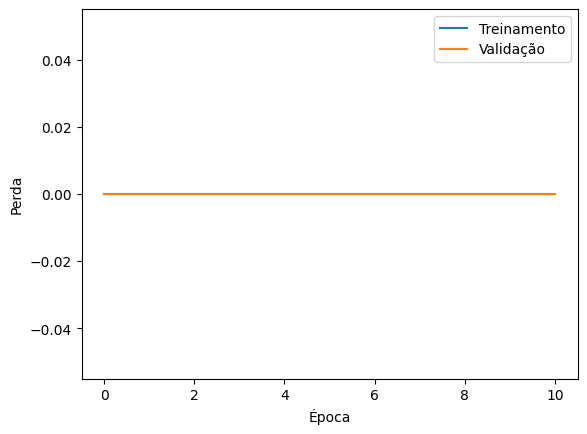

In [25]:
import matplotlib.pyplot as plt

plt.plot(history['loss'])
plt.plot(history['val_loss'])


plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treinamento', 'Validação'], loc = 'upper right')
plt.show()

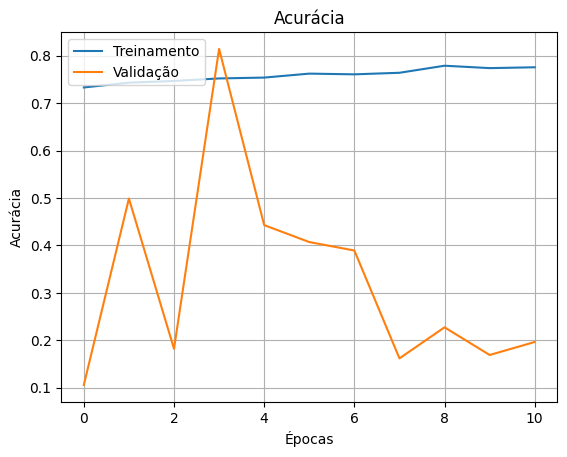

In [26]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.grid(True)
plt.show()
plt.close()

Salvando o modelo

In [27]:
preds = modelo_carregado.predict(X_test)

NameError: name 'X_test' is not defined

In [28]:
#Função da Matriz de Confusão

def plot_confusion_matrix(
        cm,
        classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues
    ):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')

In [29]:
#Gráfico da Matriz de Confusão

y_test_ = [np.argmax(x) for x in y_test]
preds_ = [np.argmax(x) for x in preds]

cm = confusion_matrix(y_test_, preds_)
plot_confusion_matrix(cm, classes=['Positive', 'Negative Positive'], title='Confusion matrix')
plt.show()
plt.close()

NameError: name 'y_test' is not defined